# Introduction

Bike sharing is one of the new transportation methods that provides benefits not only for the user but also for the environment. In the following case study we will dive deeper into Ford Go Bike, to understand use patterns as well as potential areas of improvement to maximize success.

# Data Wrangling

Before starting with the analysis is important to understand the data structure, for this purpose we research the information in: [Ford Go Bike - System Data](https://www.fordgobike.com/system-data). The data is organized in csv files:

* 2017: 6 months - 1 file

* 2018: 12 months - 1 file per month 

* 2019: 3 months - 1 file per month


In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline


### Merging files & Data structure
After initial visual exploration of files and by reading the data description it turns out that since 2018 there is one additional column, ***“bike_share_for_all_trip”***. It's unclear what does this column means so let's do a google search before actually start importing the files.

***Bike Share for All*** is a program for some bay area residents that meet certain conditions (https://www.fordgobike.com/pricing/bikeshareforall). 

In this case, I've decided to skip this column and focus the analysis on the rest, so this means that once we are combining all DF into one, the option join=inner must be set (to make sure the concatenation happens ONLY for the columns that match between files)

In [2]:

files = glob.glob("data/*.csv")

all_files = []
for file in files:
    df = pd.read_csv(file, index_col=None, header=0)
    all_files.append(df)

bike_df = pd.concat(all_files, axis=0, ignore_index=True, join = "inner")
del all_files


In [3]:
#Let's also export the DF as ONE csv 
bike_df.to_csv(path_or_buf ='full_bikes.csv',index=False)

In [5]:
bike_df.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender
0,80110,2017-12-31 16:57:39.6540,2018-01-01 15:12:50.2450,74.0,Laguna St at Hayes St,37.776435,-122.426244,43.0,San Francisco Public Library (Grove St at Hyde...,37.778768,-122.415929,96,Customer,1987.0,Male
1,78800,2017-12-31 15:56:34.8420,2018-01-01 13:49:55.6170,284.0,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,96.0,Dolores St at 15th St,37.766210,-122.426614,88,Customer,1965.0,Female
2,45768,2017-12-31 22:45:48.4110,2018-01-01 11:28:36.8830,245.0,Downtown Berkeley BART,37.870348,-122.267764,245.0,Downtown Berkeley BART,37.870348,-122.267764,1094,Customer,NaN,NaN
3,62172,2017-12-31 17:31:10.6360,2018-01-01 10:47:23.5310,60.0,8th St at Ringold St,37.774520,-122.409449,5.0,Powell St BART Station (Market St at 5th St),37.783899,-122.408445,2831,Customer,NaN,NaN
4,43603,2017-12-31 14:23:14.0010,2018-01-01 02:29:57.5710,239.0,Bancroft Way at Telegraph Ave,37.868813,-122.258764,247.0,Fulton St at Bancroft Way,37.867789,-122.265896,3167,Subscriber,1997.0,Female


# Data Exploration

After initial observation, also in the Ford Go Bike website, it was obvious that the service is provided in US and that’s centered around the bay area, which means that the data will be a representation of the user behaviour of such region. It will be interesting to identify:

*  Most used station (starting)
*  Differences between genders
*  Differences between age
*  Differences between member types

#### Initial inspection of the dataframe

In [6]:
#Total number of cols and rows
bike_df.shape

(3015214, 15)

In [7]:
#Explore data types
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015214 entries, 0 to 3015213
Data columns (total 15 columns):
duration_sec               int64
start_time                 object
end_time                   object
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             float64
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  object
member_birth_year          float64
member_gender              object
dtypes: float64(7), int64(2), object(6)
memory usage: 345.1+ MB


Now that we have a csv with our entire DF as backup and we have some insights, let's start to clean our data

In [8]:
#change data types

bike_df['end_station_id'] = bike_df['end_station_id'].fillna(0).astype(int)
bike_df['end_time'] = pd.to_datetime(bike_df['end_time'])
bike_df['start_time'] = pd.to_datetime(bike_df['start_time'])
bike_df['user_type'] = bike_df['user_type'].astype('category')

#test
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015214 entries, 0 to 3015213
Data columns (total 15 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int32
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
member_birth_year          float64
member_gender              object
dtypes: category(1), datetime64[ns](2), float64(6), int32(1), int64(2), object(3)
memory usage: 313.4+ MB


Given that we are interested in exploring the usage patterns, it will be very helpful to extract the start_time information in different columns

In [9]:
#code
bike_df['start_time_year'] = pd.DatetimeIndex(bike_df['start_time']).year
bike_df['start_time_month'] = pd.DatetimeIndex(bike_df['start_time']).month
bike_df['start_time_day'] = pd.DatetimeIndex(bike_df['start_time']).day_name()
bike_df['start_time_hour'] = pd.DatetimeIndex(bike_df['start_time']).hour

#test 
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015214 entries, 0 to 3015213
Data columns (total 19 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int32
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
member_birth_year          float64
member_gender              object
start_time_year            int64
start_time_month           int64
start_time_day             object
start_time_hour            int64
dtypes: category(1), datetime64[ns](2), float64(6), int32(1), int64(5), object(4)
memory usage: 405.5+ MB


#### Age and data accuracy

The same as above, let's also create a calculated field with the age of members. But before doing so, let's review how accurate this information might be

In [10]:
#Distribution of birth years
bike_df['member_birth_year'].value_counts()

1988.0    161501
1987.0    137740
1989.0    135770
1990.0    129036
1985.0    127480
1986.0    122981
1991.0    122767
1993.0    122626
1984.0    114866
1992.0    109310
1983.0    105713
1982.0    101591
1994.0     98261
1995.0     82608
1980.0     80378
1981.0     80234
1979.0     63903
1977.0     60190
1978.0     58003
1996.0     54486
1975.0     53585
1976.0     46658
1974.0     46556
1973.0     41359
1997.0     40009
1968.0     39668
1971.0     39222
1972.0     35336
1965.0     34797
1970.0     32485
           ...  
1933.0       343
1936.0       305
1935.0       301
1911.0       274
1941.0       211
1924.0       200
2001.0       145
1934.0       110
1920.0       106
1939.0       101
1901.0        76
1938.0        72
1940.0        70
1928.0        50
1932.0        34
1888.0        23
1927.0        21
1914.0        18
1904.0        16
1896.0        11
1907.0         7
1881.0         5
1909.0         4
1889.0         3
1878.0         3
1930.0         2
1886.0         2
1906.0        

Users from **1886** this cannot be correct, so let's set 95 years as our "max" usage age and drop all the rows whose birth year is before 1924.

In [11]:
bike_df['age'] = np.where(bike_df['member_birth_year'] > 1924, 2019 - bike_df['member_birth_year'], np.NaN)

In [12]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3015214 entries, 0 to 3015213
Data columns (total 20 columns):
duration_sec               int64
start_time                 datetime64[ns]
end_time                   datetime64[ns]
start_station_id           float64
start_station_name         object
start_station_latitude     float64
start_station_longitude    float64
end_station_id             int32
end_station_name           object
end_station_latitude       float64
end_station_longitude      float64
bike_id                    int64
user_type                  category
member_birth_year          float64
member_gender              object
start_time_year            int64
start_time_month           int64
start_time_day             object
start_time_hour            int64
age                        float64
dtypes: category(1), datetime64[ns](2), float64(7), int32(1), int64(5), object(4)
memory usage: 428.5+ MB


#### Duplicates

In [13]:
bike_df[bike_df.duplicated() == True]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,start_time_year,start_time_month,start_time_day,start_time_hour,age


#### Bike sharing general statistics

this will be useful later on, for comparison vs the visualizations

In [14]:
bike_df.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,start_time_year,start_time_month,start_time_hour,age
count,3.015214e+06,3.002777e+06,3.015214e+06,3.015214e+06,3.015214e+06,3.015214e+06,3.015214e+06,3.015214e+06,2.808247e+06,3.015214e+06,3.015214e+06,3.015214e+06,2.806120e+06
mean,8.800043e+02,1.192539e+02,3.776874e+01,-1.223531e+02,1.169892e+02,3.776888e+01,-1.223526e+02,2.654638e+03,1.982997e+03,2.018037e+03,6.400240e+00,1.352129e+01,3.594428e+01
std,2.502496e+03,1.017029e+02,1.007025e-01,1.469537e-01,1.016576e+02,1.005976e-01,1.465561e-01,1.660454e+03,1.046344e+01,6.168568e-01,3.540993e+00,4.719943e+00,1.024227e+01
min,6.100000e+01,3.000000e+00,3.726331e+01,-1.224737e+02,0.000000e+00,3.726331e+01,-1.224737e+02,1.000000e+01,1.878000e+03,2.017000e+03,1.000000e+00,0.000000e+00,1.800000e+01
25%,3.520000e+02,3.000000e+01,3.777106e+01,-1.224117e+02,3.000000e+01,3.777143e+01,-1.224108e+02,1.312000e+03,1.978000e+03,2.018000e+03,3.000000e+00,9.000000e+00,2.900000e+01
50%,5.570000e+02,8.700000e+01,3.778107e+01,-1.223983e+02,8.500000e+01,3.778127e+01,-1.223974e+02,2.531000e+03,1.985000e+03,2.018000e+03,7.000000e+00,1.400000e+01,3.400000e+01
75%,8.730000e+02,1.830000e+02,3.779539e+01,-1.222935e+02,1.820000e+02,3.779591e+01,-1.222948e+02,3.701000e+03,1.990000e+03,2.018000e+03,1.000000e+01,1.700000e+01,4.100000e+01
max,8.636900e+04,4.070000e+02,4.551000e+01,-7.357000e+01,4.070000e+02,4.551000e+01,-7.357000e+01,7.082000e+03,2.001000e+03,2.019000e+03,1.200000e+01,2.300000e+01,9.200000e+01


## Trips duration

How much time does the usual trip last?

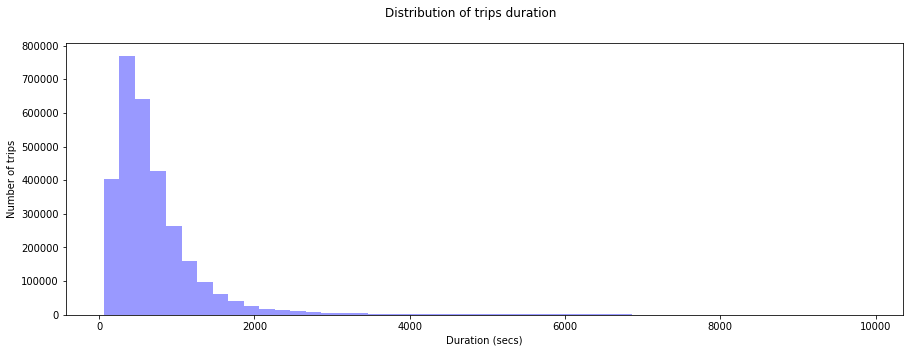

In [16]:
# from the statistics above we get minimum. The max value was set in (after initial run with real max value) 10000
bins = np.arange(61,10000,200)

#plot definition
fig = plt.figure(figsize=(15,5))
fig.suptitle('Distribution of trips duration')
sb.distplot(bike_df['duration_sec'],kde = False , bins = bins, color = "b")
plt.xlabel('Duration (secs)')
plt.ylabel('Number of trips')
plt.show()

From the previous distribution it's clear that most trips lasted 1000 secs on average this means aprox 16 mins. Comparing this result with the one computed before of statistics for the column *duration_sec* this clearly matches. This could mean that most of the users (customers or subscribers) use the service for short duration lengths. 

## Distribution of trips per year

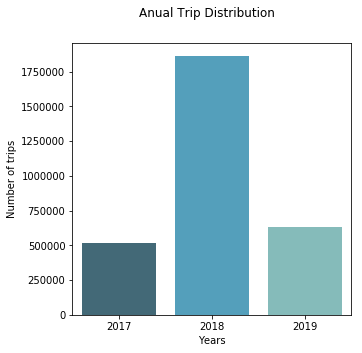

In [17]:
fig = plt.figure(figsize=(5,5))
fig.suptitle('Anual Trip Distribution')
sb.countplot(data=bike_df, x='start_time_year', palette='GnBu_d')
plt.ylabel('Number of trips')
plt.xlabel('Years');

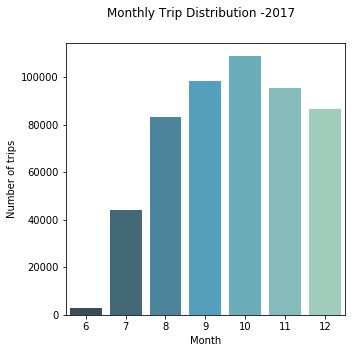

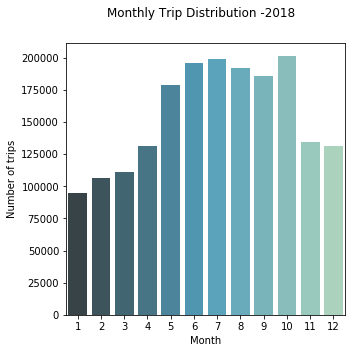

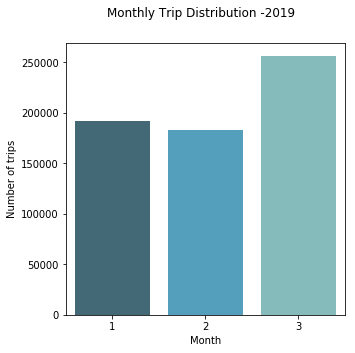

In [18]:
for i in range (2017,2020):
    fig = plt.figure(figsize=(5,5))
    fig.suptitle('Monthly Trip Distribution -' + str(i))
    sb.countplot(data=bike_df[bike_df['start_time_year'] == i], x='start_time_month', palette='GnBu_d')
    plt.ylabel('Number of trips')
    plt.xlabel('Month');

Although the data for years 2017 and 2019 is incomplete, still is possible to analyze the total number of trips per each year and the varitations. From the chart **Anual Trip Distribution** is clear that there was a expansion from 2017 until 2018, but what about 2019? If we look at the monthly progression in the following 3 charts, specially for 2018 and 2019 just in the 1st three months of 2019 the total trips were more than 125 000 exceeding the total trips in the first 3 months of 2018.

## Most popular stations (Top 10)

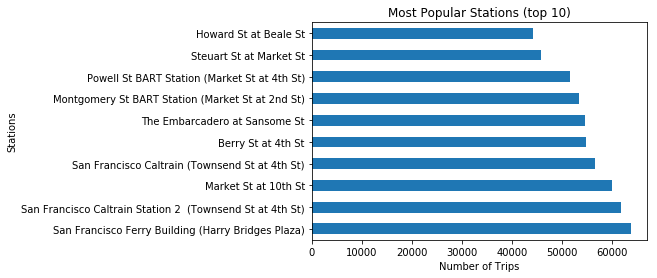

In [19]:
popular_stations = pd.value_counts(bike_df['start_station_name'])
ax = popular_stations.sort_values(ascending = False).head(10).plot.barh()
ax.set_xlabel("Number of Trips")
ax.set_ylabel("Stations")
ax.set_title("Most Popular Stations (top 10)");

The Ferry Building is the most used station (to start trips), doing a bit of research we realize that this spot is home to a ferry's terminal, restaurants, shops and markets (tuesday, thursdays and saturdays), so the uasge patterns for those days might be interesting to research.

## User behaviour in the most popular station

In [20]:
pop_station = popular_stations.index.tolist()[0]
pop_station_df = bike_df.query('start_station_name == @pop_station')

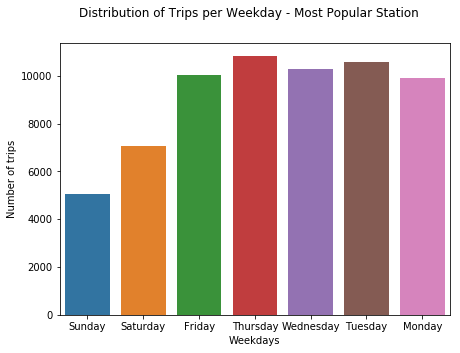

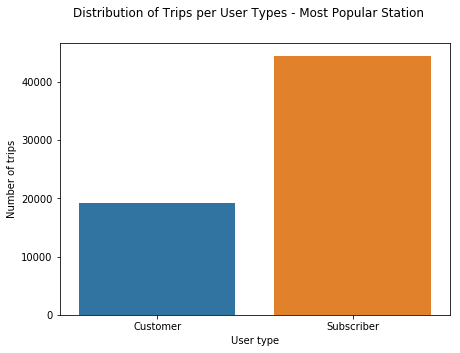

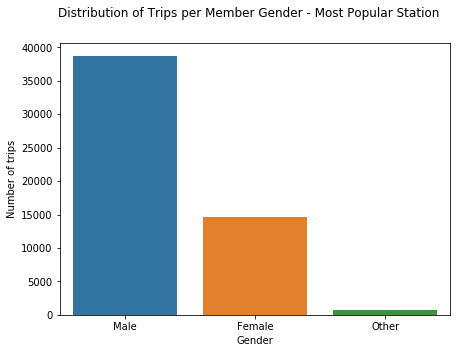

In [21]:
titles = ['Distribution of Trips per Weekday - Most Popular Station' ,'Distribution of Trips per User Types - Most Popular Station','Distribution of Trips per Member Gender - Most Popular Station']
label_x = [ 'Weekdays','User type', 'Gender']
cols_to_plot = [ 'start_time_day','user_type', 'member_gender']
for i in range (3):
    fig = plt.figure(figsize=(7,5))
    fig.suptitle(titles[i])
    sb.countplot(data=bike_df.query('start_station_name == @pop_station'), x=cols_to_plot[i])
    plt.ylabel('Number of trips')
    plt.xlabel(label_x[i]);

In [22]:
pop_station_df.query('member_gender == "Male"').describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,start_time_year,start_time_month,start_time_hour,age
count,38728.000000,38728.0,3.872800e+04,3.872800e+04,38728.000000,38728.000000,38728.000000,38728.000000,38728.000000,38728.000000,38728.000000,38728.000000,38719.000000
mean,914.906244,15.0,3.779539e+01,-1.223942e+02,65.857106,37.785335,-122.399245,2610.960468,1977.524737,2017.951250,6.577076,11.940302,41.460110
std,2376.007848,0.0,3.301935e-11,1.263646e-10,86.144087,0.012428,0.008454,1625.890459,11.281473,0.626325,3.476349,4.424309,11.237609
min,61.000000,15.0,3.779539e+01,-1.223942e+02,3.000000,37.729279,-122.453704,13.000000,1900.000000,2017.000000,1.000000,0.000000,19.000000
25%,385.000000,15.0,3.779539e+01,-1.223942e+02,14.000000,37.775946,-122.403234,1334.000000,1971.000000,2018.000000,3.000000,8.000000,33.000000
50%,604.000000,15.0,3.779539e+01,-1.223942e+02,37.000000,37.783899,-122.398436,2510.000000,1978.000000,2018.000000,7.000000,11.000000,41.000000
75%,878.000000,15.0,3.779539e+01,-1.223942e+02,81.000000,37.795392,-122.393170,3642.000000,1986.000000,2018.000000,10.000000,16.000000,48.000000
max,85287.000000,15.0,3.779539e+01,-1.223942e+02,400.000000,37.840364,-122.264488,7013.000000,2000.000000,2019.000000,12.000000,23.000000,88.000000


In [23]:
pop_station_df.query('member_gender == "Female"').describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,start_time_year,start_time_month,start_time_hour,age
count,14616.000000,14616.0,14616.000000,1.461600e+04,14616.000000,14616.000000,14616.000000,14616.000000,14609.000000,14616.000000,14616.000000,14616.000000,14606.000000
mean,1138.982143,15.0,37.795392,-1.223942e+02,66.256089,37.786047,-122.398823,2524.257663,1981.296393,2017.973522,6.527162,12.412288,37.685403
std,2524.201557,0.0,0.000000,3.382299e-12,86.827758,0.014121,0.008385,1590.577088,10.998496,0.598822,3.367828,4.538742,10.925008
min,61.000000,15.0,37.795392,-1.223942e+02,3.000000,37.729279,-122.473658,11.000000,1878.000000,2017.000000,1.000000,0.000000,18.000000
25%,466.000000,15.0,37.795392,-1.223942e+02,8.000000,37.775880,-122.403234,1260.000000,1973.000000,2018.000000,3.000000,8.000000,29.000000
50%,731.000000,15.0,37.795392,-1.223942e+02,44.000000,37.783813,-122.397405,2407.000000,1984.000000,2018.000000,7.000000,12.000000,35.000000
75%,1116.000000,15.0,37.795392,-1.223942e+02,81.000000,37.799953,-122.392741,3400.000000,1990.000000,2018.000000,9.000000,17.000000,46.000000
max,84097.000000,15.0,37.795392,-1.223942e+02,400.000000,37.880222,-122.269592,6991.000000,2001.000000,2019.000000,12.000000,23.000000,86.000000


In [24]:
pop_station_df['end_station_name'].value_counts().head(1)

The Embarcadero at Sansome St    12223
Name: end_station_name, dtype: int64

From all the data collected above, we could summarize that it seems that Mondays to Friday are the most popular days to start trips from this station, It's unclear whether the fact that markets are on tue, thu and sat have a effect on the popularity, we will need more data to really understand what are the traffic distribution in the zone when the markets are closed (for example). On the other hand Subscribers and Male's seem to be the most frequent type of users. And The Embarcadero at Sansome St is the usual destination from trips starting in this station. 


Let's analyze the start/end combination for all the data:

In [25]:
bike_df.groupby(['start_station_name', 'end_station_name'])['end_station_name'].count().sort_values(ascending = False).head()

start_station_name                                  end_station_name                                  
San Francisco Ferry Building (Harry Bridges Plaza)  The Embarcadero at Sansome St                         12223
The Embarcadero at Sansome St                       Steuart St at Market St                                7569
Berry St at 4th St                                  San Francisco Ferry Building (Harry Bridges Plaza)     7338
The Embarcadero at Sansome St                       San Francisco Ferry Building (Harry Bridges Plaza)     6191
Grand Ave at Perkins St                             19th Street BART Station                               6059
Name: end_station_name, dtype: int64

In this case, it seems like the combination between San Francisco Ferry Building (Harry Bridges Plaza) & Embarcadero at Sansome St is the one with most travels with **12223** in total 

## Usage Pattern by age: Who uses the service the most?

In [26]:
bin_edges = np.arange(15,96,10) 
bin_names = [ '15-25','25-35' ,'35-45', '45-55', '55-65','65-75', '75-85', '85-95' ]
bike_df['age_groups'] = pd.cut(bike_df['age'], bin_edges, labels = bin_names)

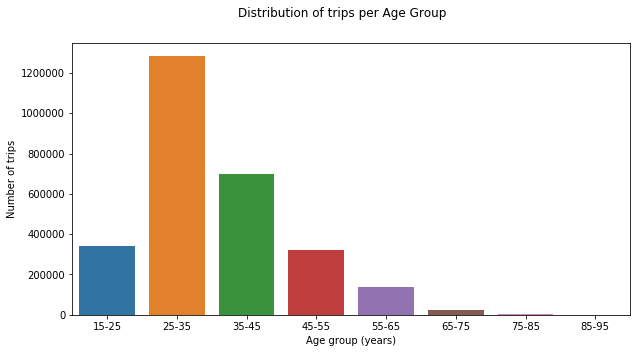

In [27]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribution of trips per Age Group')
sb.countplot(data=bike_df, x='age_groups')
plt.ylabel('Number of trips')
plt.xlabel('Age group (years)');

If we look at the trips since the service is live (mid - 2017) we can see that the Go Bike service is most popular among the ones between 25-35 and 35-45 years old. This could probably make sense if one of the use cases for using the service is commuting to work, but we'll need more data to actually review this hypothesis

## Business Growth: 

### Who uses the service the most: subscribers or customers? 

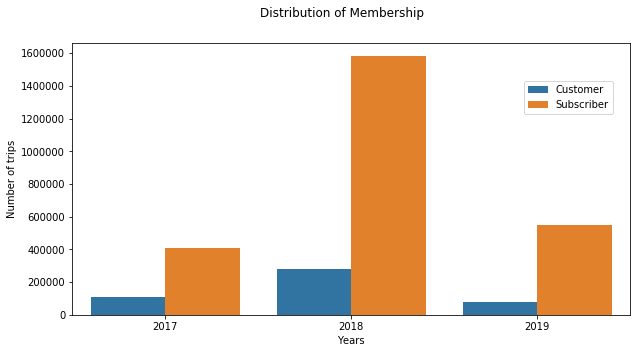

In [28]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribution of Membership')
sb.countplot(data=bike_df, x='start_time_year', hue= 'user_type')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.ylabel('Number of trips')
plt.xlabel('Years');

#### How is this reflected in the most popular station?

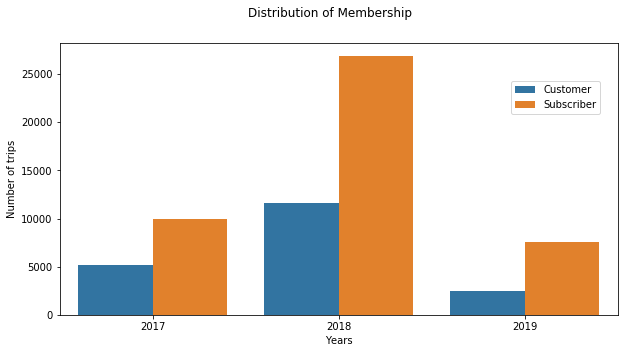

In [29]:

fig = plt.figure(figsize=(10,5))
fig.suptitle('Distribution of Membership')
sb.countplot(data=pop_station_df, x='start_time_year', hue= 'user_type')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.ylabel('Number of trips')
plt.xlabel('Years');

For both cases (all stations and the most popular starting station) the majority of user are subscribers and the ration among subscribers and customers seems to be similar as well.

### Who uses the service the most: females, males, others? 

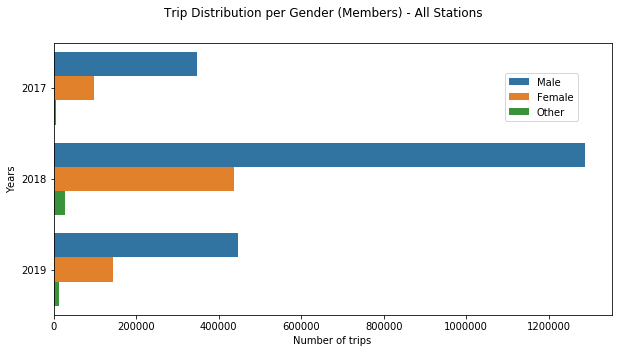

In [30]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Distribution per Gender (Members) - All Stations')
sb.countplot(data=bike_df, y='start_time_year', hue= 'member_gender')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.xlabel('Number of trips')
plt.ylabel('Years');

There is a clear majority of user identified as males using the service and such trend it has been maintained over the years. Only for 2018 there were more than 1000000 trips for males vs aprox 450000 trips for female 

#### How is this reflected in the most popular station?

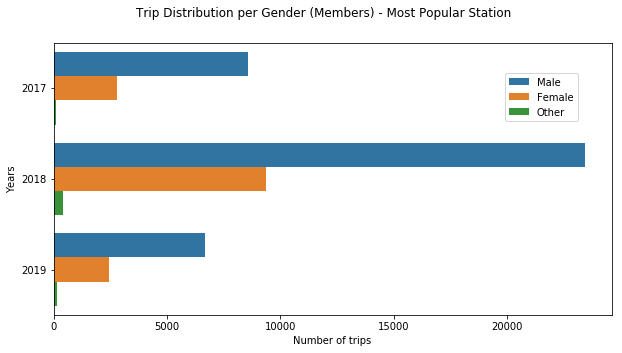

In [31]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Distribution per Gender (Members) - Most Popular Station')
sb.countplot(data=pop_station_df, y='start_time_year', hue= 'member_gender')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.xlabel('Number of trips')
plt.ylabel('Years');

There is a similar trend, as the one shown for all stations: males are the ones that use the service the most with over 20000 trips only during 2018

## Trip frequency per month: Which month usally have more trips?

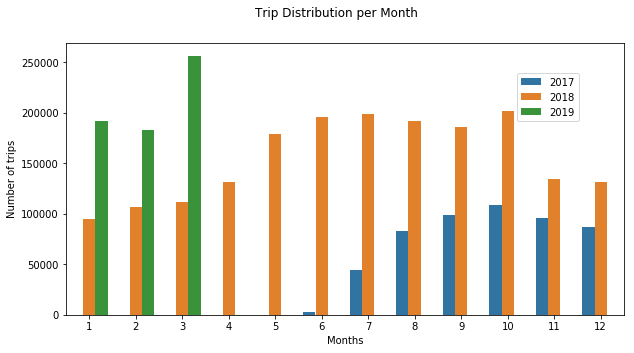

In [32]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Distribution per Month')
sb.countplot(data=bike_df, x='start_time_month', hue= 'start_time_year')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.ylabel('Number of trips')
plt.xlabel('Months');

It's very interesting to combine all the information in one visualization at the begining we used 3 charts to undertand the anual and monthly trip distribution but now it's clear that between 2018 and 2019 there is a growth trend, at least with regards to number of trips. If we only pay attention to 2018 from May until October there seems to be the most popular months, from November to April there is a decrease, it could be interesting to identify if the temperature, rain or any other weather factor impact this observation. Also it's worth to remark that although winter monts have historically less traffic the numbers for 2019 are above those in 2018.

## Trip length: Is Age a factor?

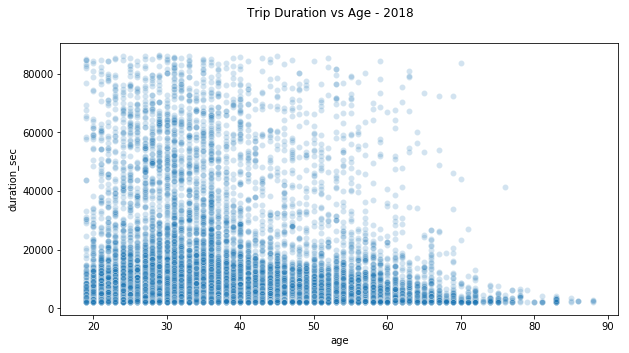

In [33]:

fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Duration vs Age - 2018')
sb.scatterplot(data=bike_df.query('start_time_year == 2018 & duration_sec >2000'), y='duration_sec', x= 'age', x_jitter = False, alpha = 0.2);

In order to have a better overview, let's observe the data corresponding to 2018 only whose total duration was more than 2000 secs. In this case there seem to be a negative correlation between age and duration. Most of the trips that lasted more than 40k secs were completed by people younger than 50 years, so we could say that the longer the trip (in time) the less age during 2018. Of course there are some outliers, we can observe there are still people registered whose age is >50 with trips over 2000. In fact, the density starts to differ the most for durations longer than 20k secs.

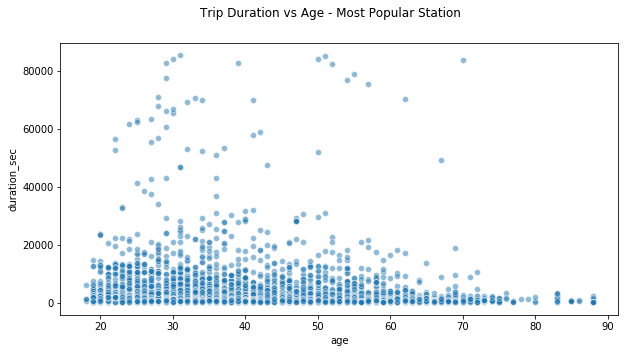

In [34]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Duration vs Age - Most Popular Station')
sb.scatterplot(data=pop_station_df, y='duration_sec', x= 'age', x_jitter = False, alpha = 0.5);

In this case, most of the trips are below 20k secs and even though there are more data points for people younger than 70 years old, we will need more data to establish a meaningful conclusion especially because it might be the case that people uses incorrect data to use the service. At the same time if we identify that most users in the Ferry building uses the service to commute to work this could introduce a bias in this observation because it might be that age it's not the main factor explaining the duration vs age correlation.

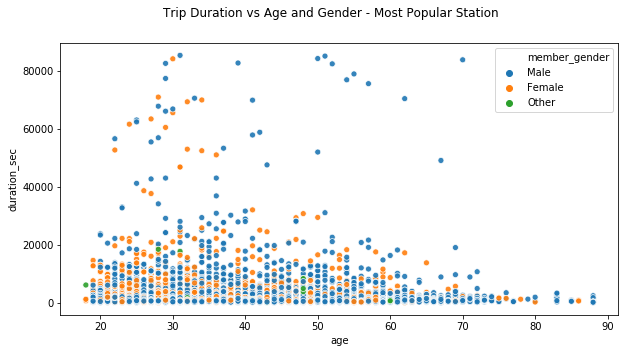

In [35]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Trip Duration vs Age and Gender - Most Popular Station')
sb.scatterplot(data=pop_station_df, y='duration_sec', x= 'age', x_jitter = False, alpha = 0.9, hue="member_gender");

## The age factor:

### Age vs Gender

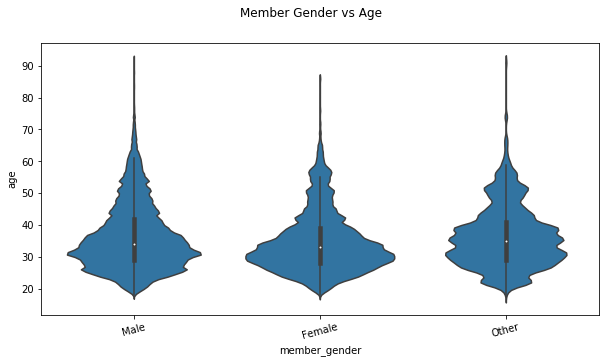

In [36]:
 # plotting
base_color = sb.color_palette()[0]
fig = plt.figure(figsize=(10,5))
fig.suptitle('Member Gender vs Age')
sb.violinplot(data = bike_df, y = 'age', x = 'member_gender',color = base_color)
plt.xticks(rotation = 15);

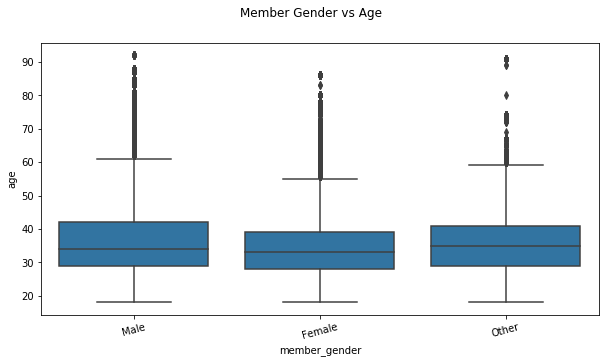

In [37]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Member Gender vs Age')
sb.boxplot(data = bike_df, y = 'age', x = 'member_gender',color = base_color)
plt.xticks(rotation = 15);

Both observations refer to the same data, if we focus in the violin plots it's easier to determine that the comparison between age and gender it's similar with most of the ages ranging from 30 to 40 for all 3 cases.

### Age vs Weekday

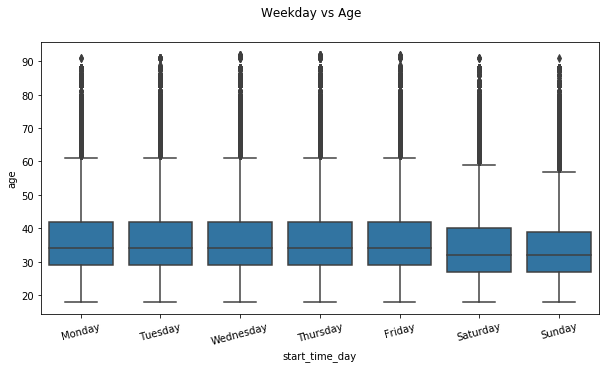

In [38]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

fig = plt.figure(figsize=(10,5))
fig.suptitle('Weekday vs Age')
sb.boxplot(data = bike_df, y = 'age', x = 'start_time_day',color = base_color, order = days)
plt.xticks(rotation = 15);

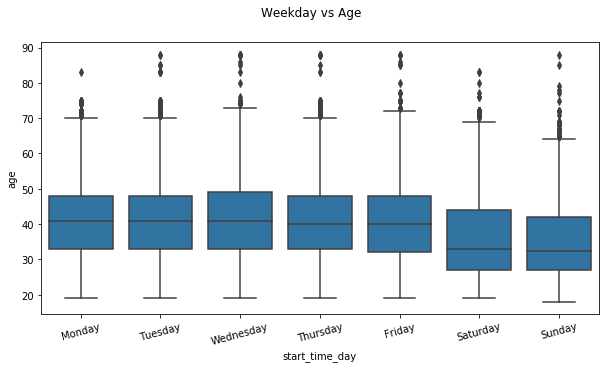

In [39]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Weekday vs Age')
sb.boxplot(data = pop_station_df, y = 'age', x = 'start_time_day',color = base_color, order = days)
plt.xticks(rotation = 15);

In both cases, the age distribution seems to be similar among the days with a slight decrease in the age mean during weekends. Does it mean that most people (30 to 50 years) uses the service from monday to friday to work? We will need more information.

### Age vs Starting Year

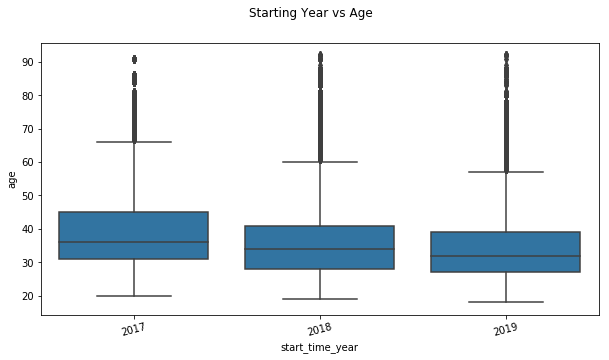

In [40]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Starting Year vs Age')
sb.boxplot(data = bike_df, y = 'age', x = 'start_time_year',color = base_color)
plt.xticks(rotation = 15);

If we analyze the ages vs starting year, it seems like almost the same (there seems to be a decrease from year to year) but at the same time there is not enough information for 2017 and 2019

### Age vs Weekday for the most popular route combination

In [41]:
pop_route = bike_df.query('start_station_name == "San Francisco Ferry Building (Harry Bridges Plaza)" & end_station_name == "The Embarcadero at Sansome St"')
pop_route.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year,start_time_year,start_time_month,start_time_hour,age
count,12223.000000,12223.0,12223.000000,1.222300e+04,12223.0,1.222300e+04,1.222300e+04,12223.000000,9305.000000,12223.000000,12223.000000,12223.000000,9303.000000
mean,1243.373149,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,2287.346233,1981.163031,2017.832283,6.689274,12.031825,37.823283
std,2672.775906,0.0,0.000000,3.368110e-12,0.0,8.164470e-12,1.867383e-11,1441.303390,11.351227,0.592747,3.285641,3.972873,11.313592
min,195.000000,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,11.000000,1911.000000,2017.000000,1.000000,0.000000,18.000000
25%,370.000000,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,1099.500000,1973.000000,2017.000000,4.000000,8.000000,30.000000
50%,501.000000,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,2240.000000,1983.000000,2018.000000,7.000000,12.000000,36.000000
75%,1279.000000,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,3119.500000,1989.000000,2018.000000,9.000000,15.000000,46.000000
max,84270.000000,15.0,37.795392,-1.223942e+02,6.0,3.780477e+01,-1.224032e+02,7013.000000,2001.000000,2019.000000,12.000000,23.000000,83.000000


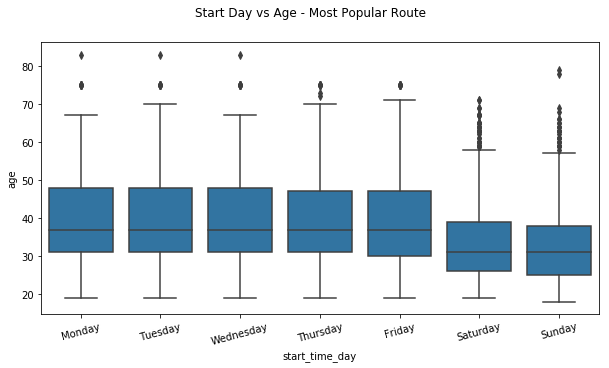

In [42]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Start Day vs Age - Most Popular Route')
sb.boxplot(data = pop_route, y = 'age', x = 'start_time_day',color = base_color, order= days)
plt.xticks(rotation = 15);

Although similar to the comparison among all stations, again it's very interesting to see the difference in age during the weekends. Unfortunately more data is required to analyze the reason behind this.

## When is it better to cycle? what does the data say?

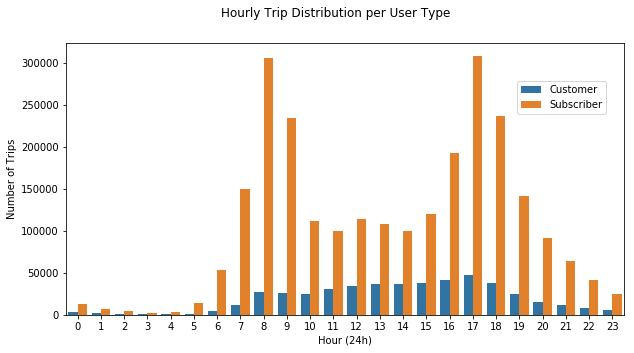

In [43]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Hourly Trip Distribution per User Type')
sb.countplot(data=bike_df, x='start_time_hour', hue= 'user_type')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.ylabel('Number of Trips')
plt.xlabel('Hour (24h)');

Customer and Subscribers seems to have a slighltly different behaviour, in the case of subscribers this is a bimodal distribution with peaks around 08:00 and 17:00, which could be another hint for the hypothesis using the service to commute to work. The customers on the other hand seem use the service more steadyly from 08:00 to 17:00 hours although there is definetlively a peak around 17:00 and a marked decrease from 19:00 on.

### What about the most popular route?

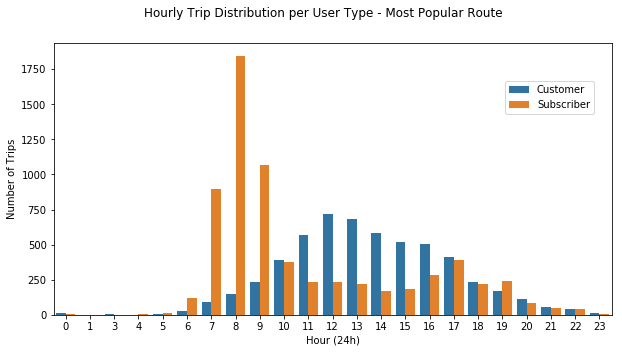

In [44]:
fig = plt.figure(figsize=(10,5))
fig.suptitle('Hourly Trip Distribution per User Type - Most Popular Route')
sb.countplot(data=pop_route, x='start_time_hour', hue= 'user_type')
plt.legend(bbox_to_anchor=(0.8,0.8), loc='center left')
plt.ylabel('Number of Trips')
plt.xlabel('Hour (24h)');

In this case, it's very interesting the peak observed between 07:00 and 9:00 for subscribers, and the normal distribution for customers with a peak around lunch times.

# Conclusions

From the data there are certain conclusions that can be made, from the most popular station, route to the distribution among ages, time of the day and preferred month. Nonetheless based on the hourly distribution usage it was very interesting to see the peaks around the morning, as well as, age decrease of usage during the weekends. Could this mean that the usage of the service is driven by the need to commute to the office? In order to evaluate this hypothesis we will need more data, especially to identify the usage drivers and potentially capitalize this by, for example, place more stations around work/office areas, make sure the appropriate amount of dock stations is available in the most popular destinations (morning and afternoon) in this way we could enable better decision making to improve service quality.
